In [1]:
%load_ext autoreload
%autoreload 2

from calc_del_lambda import import_lab_frame_spectra

#need this in memory for the following wrapper, but it only needs to be done once and it takes a while
lab = import_lab_frame_spectra('/home/agoga/Documents/nreshk/data/LabSpectra/', resolution=0)#,res*10)


In [21]:
#BEFORE RUNING THIS MAKE SURE CALC_DEL_LAMBDA HAS A LOCAL WIDTH OF AROUND 250


import scipy.constants as sc

import astropy.io.fits
import numpy as np
import os

from calc_shk import calc_targOlapf
from calc_shk import calc_shk


from calc_del_lambda import tmp_find_del_lam
from calc_del_lambda import lamda_zoom
from calc_del_lambda import pdf_from_data
from helpers import mkdir_p
from helpers import bad_spec_detection

from mk_flatolap import mk_flatolap
from matplotlib import pyplot as plt

from astropy.time import Time
from matplotlib.backends.backend_pdf import PdfPages


def print_header(header):
    for h in header.keys():
        print(h, header[h])
def mjd_from_hdu(hdu):
    return hdu[0].header['MJD-OBS']

#https://stackoverflow.com/questions/47725773/finding-an-integer-key-of-a-python-dict-that-is-closest-to-a-given-integer
def find_nearest_mjd(dd,mjd):
    low = max([d for d in dd if d<= mjd])
    high = min([d for d in dd if d>= mjd])
    nearkey = low if mjd - low <= high - mjd else high
    return nearkey
def closestKey(dic, key):
    diff = {k:abs(k - key) for k in dic}
    return min(diff, key=diff.get)

#computer specific directories
dataPath ='/home/agoga/Documents/nreshk/data/'
setName = '190406/'
#22049
#17051
#30495
#49933
#76151
#120136
#190406


obsPath = dataPath + setName+ 'obs/'
flatsPath = dataPath + setName+ 'flats/'

obsDict = dict()
for obFile in os.listdir(obsPath):
    if obFile.endswith(".fits"):
        obsHDu1 = astropy.io.fits.open(obsPath+obFile)
        if(setName.strip('/') not in obsHDu1[0].header['OBJECT']):
            continue
        obsDate = mjd_from_hdu(obsHDu1)
        #print(obFile + ' for mjd: ' + str(obsDate))
        obsDict.update({obsDate:obsHDu1})
        #print(int(obsDate))
        
#print('-------------------------')

flatDict = dict()       
for flFile in os.listdir(flatsPath):
    if flFile.endswith(".fits"):
        flatHDu1 = astropy.io.fits.open(flatsPath+flFile)
        flatDate = mjd_from_hdu(flatHDu1)
        flatDict.update({int(flatDate):flatHDu1})
#        print(int(flatDate))
#print('-------------------------')
#for k in obsDict:
#    print(closestKey(flatDict,int(k)))

#resolution for printing
res = .01
label =''

tEffLookup = {"22049":5065,
              "17051":6200,#could not find in references, google's value
              "30495":5834,
              "49933":6674,
              "76151":5761,#could not find in references, google's value
              "120136":6420,#could not find in references, google's value
              "190406":5940
            }

#todo fill this to print out in 
bad = []#[58330.3596906,58330.3634695,
      # 58553.7527935,58553.7479017,
      # 58272.4211262,58272.4248934,
      # 58354.2323109,58354.2381758]

    
#need blank arrays to append to since we don't know length due to bad spectra
data = [[],[]]
sites = []

for oK in obsDict:
    fK = closestKey(flatDict,oK)
    
    #checking 
    if abs(oK-fK) > 2:
        print('closest for: '+str(oK) +' is '+ str(abs(oK-fK)))
    oHDu = obsDict[oK]
    fHDu = flatDict[fK]
    
    #read data from files in new format
    waveGrid = oHDu[7].data
    flat = fHDu[0].data
    spec = oHDu[1].data

    #give multiple arrays of flats who's lamda values are stored in wave grid
    flatRet = mk_flatolap(waveGrid, flat)
    #return one flat array with lambda grid
    flatOlap = flatRet[1]
    lamGrid = flatRet[0]

    
    #observation key in form of 58330.3596906
    label=str(oK).replace('.','/') 

    
    #get the target data minus the flat
    targOlapf = calc_targOlapf(lamGrid, waveGrid, spec, flatOlap, label)
    
    
    #cross correlation returns a lambda offset(dlam) and save the lab spectra
    correlation = tmp_find_del_lam(lab[0]/10,lab[1], lamGrid, targOlapf,res)
    dLam = correlation[0]
    labSpec = correlation[2]
    
    #TODO
    #bad_spec_detection(lamGrid-dLam, targOlapf)
    
    #radial velocity calculation
    lamRef = 396.85
    #delta lamda / ref lamda * speed of light
    rv = dLam/ lamRef * sc.c 
    #rv from meters to km/s as desired by hk_windows
    #atm we're not going to apply the radial velocity and just use the adjusted spectra
    rv = 0#rv/10000 

    
    #lookup this star's teff
    tempEff = tEffLookup[setName.strip('/')]
    
    #find SHK with new offset to lamda grid
    shkRet = calc_shk(lamGrid-dLam, targOlapf, rv, teff=tempEff)
    shk = shkRet[0]
    windows = shkRet[1]
    print('MJD: ' + str(oK) + ' w/ shk: ' + str(shk))
    
    
    #create the directories for pdf plotting and save every intermediate data array
    first = label.split("/")[0]
    second = label.split("/")[1]
    mkdir_p("output/"+setName+first+'/')
    np.savez("output/"+setName+first+"/"+ second+"_data", targOlapf=targOlapf,flatOlap=flatOlap, lamGrid=lamGrid, adjLamGrid=lamGrid-dLam,windows=windows)

    
    pdf_from_data(lamGrid, labSpec,lamGrid-dLam, targOlapf, flatOlap,windows,shk, "output/"+setName+first+"/",second,.3)
    
    #throwing out bad spectra
    if(shk < 0):
        continue
    if(oK in bad):
        continue
        
    
    data[0].append(mjd_from_hdu(obsDict[oK]))
    data[1].append(shk)
    sites.append(obsDict[oK][0].header['SITEID'])
#output of this wrapper is an array of data, MJD vs SHK,
#and an equivelant length array with strings correlating to the site

MJD: 58412.0027436 w/ shk: 0.1741085408818929
MJD: 58412.0104082 w/ shk: 0.17321151263721796
closest for: 58643.3735895 is 2.3735894999990705
MJD: 58643.3735895 w/ shk: 0.19014350490648477
closest for: 58643.3812644 is 2.381264399999054
MJD: 58643.3812644 w/ shk: 0.18864144167752808
closest for: 58358.8111498 is 3.811149799999839
MJD: 58358.8111498 w/ shk: 0.20043625875570723
closest for: 58358.8188232 is 3.818823200002953
MJD: 58358.8188232 w/ shk: 0.1956571733626567
MJD: 58271.2530445 w/ shk: -0.03734792245997361
MJD: 58271.2582576 w/ shk: 0.03328273295269577
closest for: 58297.1813422 is 2.1813421999977436
MJD: 58297.1813422 w/ shk: 0.11176329961099822
closest for: 58297.186502 is 2.1865019999968354
MJD: 58297.186502 w/ shk: 0.11680174432428507
closest for: 58331.3851305 is 2.3851304999989225
MJD: 58331.3851305 w/ shk: 0.18087643933677897
closest for: 58331.3902916 is 2.390291600000637
MJD: 58331.3902916 w/ shk: 0.15161257049587915
MJD: 58408.0018862 w/ shk: 0.18311970022813048
MJD:

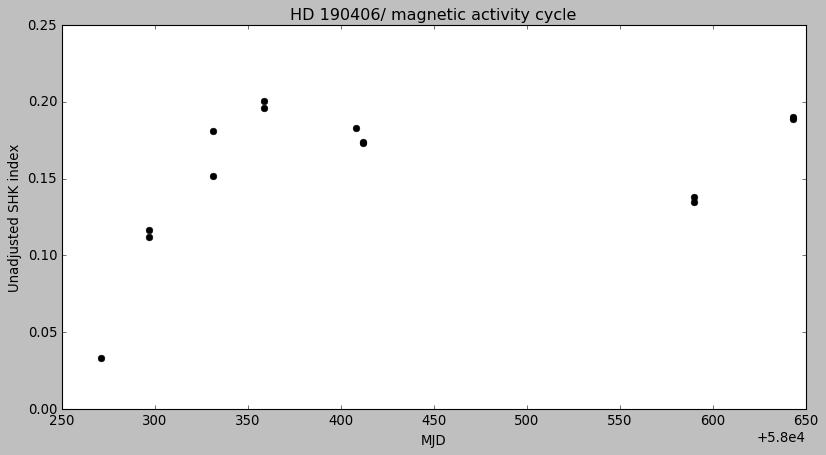

In [22]:

#for i in oldData[0]:
#    data[0].append(i)
#for i in oldData[1]:
#    data[1].append(i)
#for i in oldSites:
#    sites.append(i)
    
shkArray = np.asarray(data)
siteArray = np.asarray(sites)
plt.figure(figsize=(12,6))    
#t= Time(shkArray[0], format='mjd')
#t.format = 'decimalyear'
   
plt.plot(shkArray[0],shkArray[1], 'ko')
plt.title('HD '+setName+' magnetic activity cycle')
plt.xlabel('MJD')
plt.ylabel('Unadjusted SHK index')
#plt.savefig('output/'+setName+'shk_time_series.pdf')
plt.show()
plt.close()

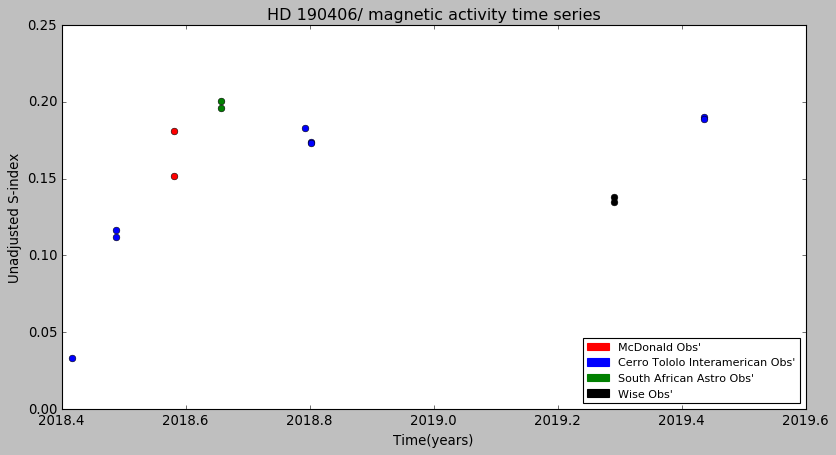

In [23]:
from astropy.time import Time

import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12,6))

newT = shkArray[0][siteArray=='lsc']
newVal = shkArray[1][siteArray=='lsc']
t= Time(newT, format='mjd')
t.format = 'decimalyear'
plt.plot(t.value,newVal, 'bo')

newT = shkArray[0][siteArray=='cpt']
newVal = shkArray[1][siteArray=='cpt']
t= Time(newT, format='mjd')
t.format = 'decimalyear'
plt.plot(t.value,newVal, 'go')

newT = shkArray[0][siteArray=='elp']
newVal = shkArray[1][siteArray=='elp']
t= Time(newT, format='mjd')
t.format = 'decimalyear'
plt.plot(t.value,newVal, 'ro')


newT = shkArray[0][siteArray=='tlv']
newVal = shkArray[1][siteArray=='tlv']
t= Time(newT, format='mjd')
t.format = 'decimalyear'
plt.plot(t.value,newVal, 'ko')
#plt.plot(shkArray[0][shkArray[2]=='cpt'],shkArray[1][shkArray[2]=='cpt'], 'go')

rl = mpatches.Patch(color='red', label='McDonald Obs\'')
bl = mpatches.Patch(color='blue', label='Cerro Tololo Interamerican Obs\'')
gl = mpatches.Patch(color='green', label='South African Astro Obs\'')
kl = mpatches.Patch(color='black', label='Wise Obs\'')
#sLeg = mpatches.Patch(color='blue', label='combined s val')
plt.legend(handles=[rl,bl,gl,kl],prop={'size': 10}, loc=4)

plt.style.use('classic')
#plt.rcParams['axes.titlesize'] = 22
ax.ticklabel_format(useOffset=False)
plt.title('HD '+setName+' magnetic activity time series')
plt.xlabel('Time(years)')
plt.ylabel('Unadjusted S-index')
plt.savefig('output/'+setName+setName.strip('/')+'_shk_time_series.pdf')
plt.show()
plt.close()

In [ ]:
pi = sc.pi
p1 = 1.968
a1 = 0.0118
f1 = 6.27

p2 = 1.412
a2 = 0.0102
f2 = 4.51
sList = np.zeros((4,100))
for i in range(0,len(sList[0])):
    t = 2018.5 + (i/100)
    s1 = a1*np.sin(2*pi*(t+f1)/p1) 
    s2 = a2*np.sin(2*pi*(t+f2)/p2) 
    s = s1+s2
    sList[0,i]=t
    sList[1,i]=s1
    sList[2,i]=s2
    sList[3,i]=s
    
shkArray = np.asarray(tmpArray)


from astropy.time import Time
import matplotlib.patches as mpatches

plt.figure(figsize=(16,6))    
#plt.plot(sList[0],sList[1],'g-')
#plt.plot(sList[0],sList[2],'r-')
#plt.plot(sList[0],sList[3],'b-')

    
t= Time(shkArray[0], format='mjd')
t.format = 'decimalyear'
print(t)
plt.plot(t.value,shkArray[1],'ko')#-np.mean(shkArray[1]), 'ko')
plt.title('HD 17051 magnetic activity cycle')
plt.xlabel('Time(years)')
plt.ylabel('S index(unadjusted)')
#shkLeg = mpatches.Patch(color='black', label='shk values')
#magLeg = mpatches.Patch(color='red', label='magnetic')
#rotLeg = mpatches.Patch(color='green', label='rotation')
#sLeg = mpatches.Patch(color='blue', label='combined s val')
#plt.legend(handles=[shkLeg,magLeg,rotLeg,sLeg])
#plt.axhline(linewidth=1, color='k')
plt.savefig('images/shk_adjusted_series.jpg')
plt.show()
plt.close()
